<a href="https://colab.research.google.com/github/sayakpaul/Supervised-Contrastive-Learning-in-TensorFlow-2/blob/master/Fully_Supervised_Training_Flowers_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
!nvidia-smi

Thu May 28 13:26:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install wandb -q
import wandb
wandb.login()

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

In [0]:
import os
os.environ['WANDB_DISABLE_CODE'] = 'True'

## Flowers dataset

In [6]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


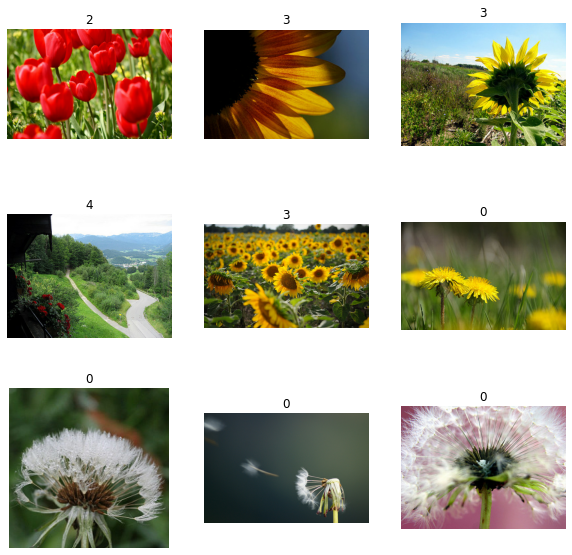

In [7]:
# Reference: https://keras.io/guides/transfer_learning/
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis('off')

In [0]:
IMG_SHAPE = 128
BS = 64
AUTO = tf.data.experimental.AUTOTUNE

# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)
# I did not use all the augmentation policies proposed in the above paper

@tf.function
def custom_augment(image, label):        
    # Random flips
    image = random_apply(tf.image.flip_left_right, image, p=0.5)
    
    # Randomly apply transformation (color distortions) with probability p.
    image = random_apply(color_jitter, image, p=0.4)
    image = random_apply(color_drop, image, p=0.2)

    return (image, label)

@tf.function
def color_jitter(x, s=0.5):
    # one can also shuffle the order of following augmentations
    # each time they are applied.
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    x = tf.clip_by_value(x, 0, 1)
    return x

@tf.function
def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))

    return (image, label)

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BS)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

## Model building and training

In [0]:
def get_training_model(optimizer=tf.keras.optimizers.Adam()):
    resnet50 = tf.keras.applications.ResNet50(weights=None, include_top=False)

    model = tf.keras.Sequential([
        resnet50,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(5)
    ])

    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
    
    return model

In [10]:
wandb.init(project="scl", entity="authors", id="fully-supervised-flowers-augment")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

model = get_training_model()

start = time.time()
model.fit(train_ds,
          validation_data=validation_ds,
          epochs=50,
          callbacks=[WandbCallback(), es])
end = time.time()
wandb.log({"training_time": end - start})

Epoch 1/50
49/49 [==============================] - 11s 224ms/step - loss: 2.1917 - accuracy: 0.3532 - val_loss: 1.8625 - val_accuracy: 0.2036
Epoch 2/50
49/49 [==============================] - 8s 169ms/step - loss: 1.4962 - accuracy: 0.4651 - val_loss: 2.0977 - val_accuracy: 0.2036
Epoch 3/50
49/49 [==============================] - 8s 170ms/step - loss: 1.4144 - accuracy: 0.4769 - val_loss: 2.6413 - val_accuracy: 0.2036
Epoch 00003: early stopping


What happens if we don't incorporate the `EarlyStopping` callback?

In [11]:
wandb.init(project="scl", entity="authors", id="fully-supervised-flowers-augment-no-es")

no_es_model = get_training_model()

start = time.time()
no_es_model.fit(train_ds,
          validation_data=validation_ds,
          epochs=50,
          callbacks=[WandbCallback()])
end = time.time()
wandb.log({"training_time": end - start})

Epoch 1/50
49/49 [==============================] - 11s 221ms/step - loss: 2.3541 - accuracy: 0.3452 - val_loss: 20.2894 - val_accuracy: 0.2055
Epoch 2/50
49/49 [==============================] - 10s 211ms/step - loss: 1.4836 - accuracy: 0.4426 - val_loss: 1.6966 - val_accuracy: 0.2055
Epoch 3/50
49/49 [==============================] - 8s 170ms/step - loss: 1.4005 - accuracy: 0.4644 - val_loss: 1.8671 - val_accuracy: 0.2036
Epoch 4/50
49/49 [==============================] - 8s 170ms/step - loss: 1.4022 - accuracy: 0.4484 - val_loss: 1.9683 - val_accuracy: 0.2036
Epoch 5/50
49/49 [==============================] - 8s 169ms/step - loss: 1.3833 - accuracy: 0.4667 - val_loss: 2.1779 - val_accuracy: 0.2055
Epoch 6/50
49/49 [==============================] - 8s 168ms/step - loss: 1.3265 - accuracy: 0.4737 - val_loss: 2.0001 - val_accuracy: 0.2127
Epoch 7/50
49/49 [==============================] - 8s 166ms/step - loss: 1.2591 - accuracy: 0.5071 - val_loss: 1.9834 - val_accuracy: 0.2527
Epo